# 프로젝트 : 모델 바꿔보기

## 데이터 전처리하기

In [1]:
import csv
import io
import json
import os
import glob
import math

import click
from loguru import logger
from PIL import Image
import ray
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization

/home/ssac10/anaconda3/envs/aiffel/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' #CPU 사용
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

workdir = os.path.join(os.getenv('HOME'),'aiffel/mpii')
os.chdir(workdir)

num_train_shards = 64
num_val_shards = 8
ray.init()
tf.get_logger().setLevel('ERROR')

2021-05-07 17:02:46,600	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


In [3]:
json_file_path = './mpii_human_pose_v1_u12_2/train.json'

with open(json_file_path) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2) # json beautify
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [4]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

## tfrecord 파일 만들기

In [5]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        # train_0001_of_0064.tfrecords
        build_single_tfrecord.remote(
            chunk, './tfrecords_mpii/{}_{}_of_{}.tfrecords'.format(
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

In [6]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n - 1):
        results.append(l[start:start + size])
        start += size
    results.append(l[start:])
    return results

In [7]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno_list in chunk:
            tf_example = generate_tfexample(anno_list)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

In [8]:
def generate_tfexample(anno):
    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    # 0 - invisible, 1 - occluded, 2 - visible
    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [9]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy(
        )  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [10]:
print('Start to parse annotations.')
if not os.path.exists('./tfrecords_mpii'):
    os.makedirs('./tfrecords_mpii')

Start to parse annotations.


In [11]:
with open('./mpii_human_pose_v1_u12_2/train.json') as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, './images/')
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])
    del (train_annos)

First train annotation:  {'filename': '015601864.jpg', 'filepath': './images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [12]:
with open('./mpii_human_pose_v1_u12_2/validation.json') as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, './images/') for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    del (val_annos)

First val annotation:  {'filename': '005808361.jpg', 'filepath': './images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'center': [966.0, 340.0], 'scale': 4.718488}


In [13]:
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

Start to build TF Records.
(pid=19812) start to build tf records for ./tfrecords_mpii/train_0012_of_0064.tfrecords
(pid=19815) start to build tf records for ./tfrecords_mpii/train_0008_of_0064.tfrecords
(pid=19821) start to build tf records for ./tfrecords_mpii/train_0004_of_0064.tfrecords
(pid=19813) start to build tf records for ./tfrecords_mpii/train_0011_of_0064.tfrecords
(pid=19814) start to build tf records for ./tfrecords_mpii/train_0010_of_0064.tfrecords
(pid=19820) start to build tf records for ./tfrecords_mpii/train_0001_of_0064.tfrecords
(pid=19819) start to build tf records for ./tfrecords_mpii/train_0005_of_0064.tfrecords
(pid=19816) start to build tf records for ./tfrecords_mpii/train_0007_of_0064.tfrecords
(pid=19818) start to build tf records for ./tfrecords_mpii/train_0006_of_0064.tfrecords
(pid=19811) start to build tf records for ./tfrecords_mpii/train_0009_of_0064.tfrecords
(pid=19817) start to build tf records for ./tfrecords_mpii/train_0002_of_0064.tfrecords
(pid=

(pid=19816) finished building tf records for ./tfrecords_mpii/train_0035_of_0064.tfrecords
(pid=19816) start to build tf records for ./tfrecords_mpii/train_0047_of_0064.tfrecords
(pid=19819) finished building tf records for ./tfrecords_mpii/train_0037_of_0064.tfrecords
(pid=19819) start to build tf records for ./tfrecords_mpii/train_0048_of_0064.tfrecords
(pid=19817) finished building tf records for ./tfrecords_mpii/train_0040_of_0064.tfrecords
(pid=19817) start to build tf records for ./tfrecords_mpii/train_0049_of_0064.tfrecords
(pid=19811) finished building tf records for ./tfrecords_mpii/train_0038_of_0064.tfrecords
(pid=19811) start to build tf records for ./tfrecords_mpii/train_0050_of_0064.tfrecords
(pid=19818) finished building tf records for ./tfrecords_mpii/train_0039_of_0064.tfrecords
(pid=19818) start to build tf records for ./tfrecords_mpii/train_0051_of_0064.tfrecords
(pid=19815) finished building tf records for ./tfrecords_mpii/train_0036_of_0064.tfrecords
(pid=19815) st

In [14]:
print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

Successfully wrote 25204 annotations to TF Records.


## Data Label로 만들기

In [2]:
# preprocess.py

class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y)

        # print (image.shape, heatmaps.shape, type(heatmaps))

        return image, heatmaps

    def parse_tfexample(self, example_proto):
            image_feature_description = {
                'image/height': tf.io.FixedLenFeature([], tf.int64),
                'image/width': tf.io.FixedLenFeature([], tf.int64),
                'image/depth': tf.io.FixedLenFeature([], tf.int64),
                'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
                'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
                'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
                'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
                'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
                'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
                'image/encoded': tf.io.FixedLenFeature([], tf.string),
                'image/filename': tf.io.FixedLenFeature([], tf.string),
            }
            return tf.io.parse_single_example(example_proto,
                                              image_feature_description)

    def crop_roi(self, image, features, margin=0.2):
            img_shape = tf.shape(image)
            img_height = img_shape[0]
            img_width = img_shape[1]
            img_depth = img_shape[2]

            keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
            keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
            center_x = features['image/object/center/x']
            center_y = features['image/object/center/y']
            body_height = features['image/object/scale'] * 200.0

            # keypoint 중 유효한값(visible = 1) 만 사용합니다.
            masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
            masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

            # min, max 값을 찾습니다.
            keypoint_xmin = tf.reduce_min(masked_keypoint_x)
            keypoint_xmax = tf.reduce_max(masked_keypoint_x)
            keypoint_ymin = tf.reduce_min(masked_keypoint_y)
            keypoint_ymax = tf.reduce_max(masked_keypoint_y)

            # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
            xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
            xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
            ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
            ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

            # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
            effective_xmin = xmin if xmin > 0 else 0
            effective_ymin = ymin if ymin > 0 else 0
            effective_xmax = xmax if xmax < img_width else img_width
            effective_ymax = ymax if ymax < img_height else img_height
            effective_height = effective_ymax - effective_ymin
            effective_width = effective_xmax - effective_xmin

            image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
            new_shape = tf.shape(image)
            new_height = new_shape[0]
            new_width = new_shape[1]

            # shift all keypoints based on the crop area
            effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
            effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

            return image, effective_keypoint_x, effective_keypoint_y

    def make_heatmaps(self, features, keypoint_x, keypoint_y):
            v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
            x = tf.cast(tf.math.round(keypoint_x * self.heatmap_shape[0]), dtype=tf.int32)
            y = tf.cast(tf.math.round(keypoint_y * self.heatmap_shape[1]), dtype=tf.int32)

            num_heatmap = self.heatmap_shape[2]
            heatmap_array = tf.TensorArray(tf.float32, 16)

            for i in range(num_heatmap):
                gaussian = self.generate_2d_guassian(self.heatmap_shape[1], self.heatmap_shape[0], y[i], x[i], v[i])
                heatmap_array = heatmap_array.write(i, gaussian)

            heatmaps = heatmap_array.stack()
            heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)

            return heatmaps

    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
            """
            "The same technique as Tompson et al. is used for supervision. A MeanSquared Error (MSE) loss is
            applied comparing the predicted heatmap to a ground-truth heatmap consisting of a 2D gaussian
            (with standard deviation of 1 px) centered on the keypoint location."

            https://github.com/princeton-vl/pose-hg-train/blob/master/src/util/img.lua#L204
            """
            heatmap = tf.zeros((height, width))

            # this gaussian patch is 7x7, let's get four corners of it first
            xmin = x0 - 3 * sigma
            ymin = y0 - 3 * sigma
            xmax = x0 + 3 * sigma
            ymax = y0 + 3 * sigma
            # if the patch is out of image boundary we simply return nothing according to the source code
            # [1]"In these cases the joint is either truncated or severely occluded, so for
            # supervision a ground truth heatmap of all zeros is provided."
            if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
                return heatmap

            size = 6 * sigma + 1
            x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

            # the center of the gaussian patch should be 1
            center_x = size // 2
            center_y = size // 2

            # generate this 7x7 gaussian patch
            gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

            # part of the patch could be out of the boundary, so we need to determine the valid range
            # if xmin = -2, it means the 2 left-most columns are invalid, which is max(0, -(-2)) = 2
            patch_xmin = tf.math.maximum(0, -xmin)
            patch_ymin = tf.math.maximum(0, -ymin)
            # if xmin = 59, xmax = 66, but our output is 64x64, then we should discard 2 right-most columns
            # which is min(64, 66) - 59 = 5, and column 6 and 7 are discarded
            patch_xmax = tf.math.minimum(xmax, width) - xmin
            patch_ymax = tf.math.minimum(ymax, height) - ymin

            # also, we need to determine where to put this patch in the whole heatmap
            heatmap_xmin = tf.math.maximum(0, xmin)
            heatmap_ymin = tf.math.maximum(0, ymin)
            heatmap_xmax = tf.math.minimum(xmax, width)
            heatmap_ymax = tf.math.minimum(ymax, height)

            # finally, insert this patch into the heatmap
            indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
            updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

            count = 0

            for j in tf.range(patch_ymin, patch_ymax):
                for i in tf.range(patch_xmin, patch_xmax):
                    indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                    updates = updates.write(count, gaussian_patch[j][i])
                    count += 1

            heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

            return heatmap

## 모델 생성

In [3]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,# lift channels first
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

In [4]:
def HourglassModule(inputs, order, filters, num_residual):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L3
    """
# Upper branch
    up1 = BottleneckBlock(inputs, filters, downsample=False)

    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

# Lower branch
    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

In [5]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

In [6]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), num_stack=4, num_residual=1,
        num_heatmap=16):
    """
    https://github.com/princeton-vl/pose-hg-train/blob/master/src/models/hg.lua#L33
    """
    inputs = Input(shape=input_shape)

# initial processing of the image
    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

# predict 256 channels like a fully connected layer.
        x = LinearLayer(x, 256)

# predict final channels, which is also the number of predicted heatmap
        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

# if it's not the last stack, we need to add predictions backif i < num_stack - 1:
        y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
        y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
        x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')


In [9]:
model = StackedHourglassNetwork()

In [10]:
model.summary()

Model: "stacked_hourglass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 128, 64) 0           batch_normalization[0][0]        
__________________________________________________________________________________

## 학습 엔진 만들기

In [7]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

In [8]:
def automatic_gpu_usage() :
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

### Trainer Class

In [14]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate,
                 version='0.0.1',
                 start_epoch=1,
                 tensorboard_dir='./logs'):
        self.start_epoch = start_epoch
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        # "we use rmsprop with a learning rate of 2.5e-4.""
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.tensorboard_dir = tensorboard_dir
        self.best_model = None
        self.version = version

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.experimental_run_v2(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.experimental_run_v2(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        summary_writer = tf.summary.create_file_writer(self.tensorboard_dir)
        summary_writer.set_as_default()

        for epoch in range(self.start_epoch, self.epochs + 1):
            tf.summary.experimental.set_step(epoch)

            self.lr_decay()
            tf.summary.scalar('epoch learning rate',
                              self.current_learning_rate)

            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))
            tf.summary.scalar('epoch train loss', train_loss)

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            tf.summary.scalar('epoch val loss', val_loss)

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = './models/model-v{}-epoch-{}-loss-{:.4f}.h5'.format(
            self.version, epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [6]:
def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [14]:
def train(epochs, start_epoch, learning_rate, tensorboard_dir, checkpoint,
          num_heatmap, batch_size, train_tfrecords, val_tfrecords, version):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(os.path.join('./models')):
        os.makedirs(os.path.join('./models/'))

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
        if checkpoint and os.path.exists(checkpoint):
            model.load_weights(checkpoint)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate,
            start_epoch=start_epoch,
            version=version,
            tensorboard_dir=tensorboard_dir)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [25]:
tfrecords_dir = './tfrecords_mpii/'
train_tfrecords = os.path.join(tfrecords_dir, 'train*')
val_tfrecords = os.path.join(tfrecords_dir, 'val*')
epochs = 10
batch_size = 8
num_heatmap = 16
tensorboard_dir = './logs/'
learning_rate = 0.0007
start_epoch = 1

automatic_gpu_usage()

pretrained_path = None # './models_old/model-v0.0.2-epoch-15-loss-1.1013.h5'

In [26]:
%load_ext tensorboard
%tensorboard --logdir {tensorboard_dir}

Reusing TensorBoard on port 6007 (pid 19374), started 0:11:42 ago. (Use '!kill 19374' to kill it.)

In [ ]:
train(epochs, start_epoch, learning_rate, tensorboard_dir, pretrained_path,
      num_heatmap, batch_size, train_tfrecords, val_tfrecords, '0.0.1')

## Simple Baseline

In [11]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

In [12]:
upconv = _make_deconv_layer(3)
final_layer = tf.keras.layers.Conv2D(16, kernel_size=(1,1), padding='same')

In [13]:
def Simplebaseline(input_shape=(256, 256, 3)):
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
    inputs = tf.keras.Input(shape=input_shape)

    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)
    model = tf.keras.Model(inputs, out, name='simple_baseline')
    
    return model

In [14]:
model = Simplebaseline()

model.summary()

Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


In [15]:
def train(epochs, start_epoch, learning_rate, tensorboard_dir, checkpoint,
          num_heatmap, batch_size, train_tfrecords, val_tfrecords, version):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(os.path.join('./models')):
        os.makedirs(os.path.join('./models/'))

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = Simplebaseline(IMAGE_SHAPE)
        if checkpoint and os.path.exists(checkpoint):
            model.load_weights(checkpoint)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate,
            start_epoch=start_epoch,
            version=version,
            tensorboard_dir=tensorboard_dir)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [16]:
tfrecords_dir = './tfrecords_mpii/'
train_tfrecords = os.path.join(tfrecords_dir, 'train*')
val_tfrecords = os.path.join(tfrecords_dir, 'val*')
epochs = 10
batch_size = 8
num_heatmap = 16
tensorboard_dir = './logs/'
learning_rate = 0.0007
start_epoch = 1

automatic_gpu_usage()

pretrained_path = None # './models_old/model-v0.0.2-epoch-15-loss-1.1013.h5'

Physical devices cannot be modified after being initialized


In [ ]:
train(epochs, start_epoch, learning_rate, tensorboard_dir, pretrained_path,
      num_heatmap, batch_size, train_tfrecords, val_tfrecords, '0.0.2')

## 모델 학습 결과 비교

In [20]:
hourglass_loss = [2.7814, 2.5838, 2.4523, 2.4379, 2.3741, 2.3449, 2.3288, 2.2621, 2.2621, 2.2457]
simplebase_loss = [6.3482, 6.3402, 6.3081, 6.3081, 6.3081, 6.3081, 6.3081, 6.2973, 6.2971, 6.2915]

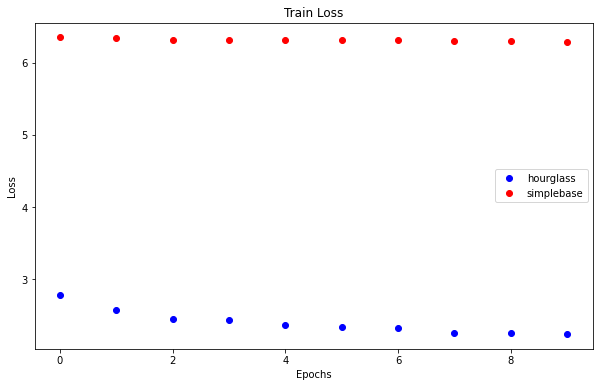

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hourglass_loss, 'bo', label='hourglass')
plt.plot(simplebase_loss, 'ro', label='simplebase')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.legend()
plt.show()

Hourglass | Simplebaseline
- | - 
![alt](./result_images/test00_hg.png) | ![alt](./result_images/test00_sb.png)

Hourglass | Simplebaseline
- | - 
![alt](./result_images/test01_hg.png) | ![alt](./result_images/test01_sb.png)

## 회고록

- 모델을  Simplebaseline으로 교체하면 에러가 발생하여 학습이 진행되지 않는 문제가 있었다. 해당 문제는 Simplebaseline에서 resnet을 불러올 때 함수 바깥에서 불러와서 발생하는 문제였다. resnet을 불러올 때 함수 내부에서 불러오면 정상적으로 학습을 진행할 수 있었다.
- 학습 결과를 보니 노드에서 성능이 좋다고 한 Simplebaseline은 전혀 다른 성능을 보여주었고, 오히려 Hourglass쪽이 더 좋은 성능을 보여줬다. Hourglass도 일부 부정확한 부분은 있으나 칼만 필터 등을 이용하여 노이즈에 유연하게 대처한다면 사용 가능성이 있다고 생각한다.